In [1]:
import requests
from __future__ import division, print_function
humpacks_url = "http://www.flukebook.org/listImages.jsp?genus=Megaptera&species=novaeangliae"
r = requests.get(humpacks_url)
print(r.status_code)

200


In [2]:
img_points_info = r.json()

In [3]:
img_points_info['mediaAssets'][0]

{u'catalogNumber': u'53414173-838e-44ad-be00-ca9daf44d78b',
 u'individualID': u'450194',
 u'referenceImageURL': u'http://www.flukebook.org/caribwhale_data_dir/encounters/5/3/53414173-838e-44ad-be00-ca9daf44d78b/extract53414173-838e-44ad-be00-ca9daf44d78b.jpg',
 u'referencePoints': [{u'x': u'50.62255358807083', u'y': u'48.3215284249767'},
  {u'x': u'1355.3038210624418', u'y': u'202.49021435228332'},
  {u'x': u'2404.5712954333644', u'y': u'36.816402609506056'}]}

In [4]:
from train_utils import dataset_loc
from os.path import exists, join
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
imgs_dir = join(dataset_loc, "Flukes/Flukebook/images")
def downloadImage(img_url, cache=True):
    fn = img_url.split('/')[-1]
    stored_fn = join(imgs_dir, fn)
    if (not cache) or not exists(stored_fn):
        r = requests.get(img_url, stream=True)
        with open(stored_fn, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
    return stored_fn

def displayPoints(imginfo, cache=True):
    # first download the image if it's not there
    imgfn = downloadImage(imginfo['referenceImageURL'], cache=cache)
    img = cv2.imread(imgfn)
    for pt in imginfo['referencePoints']:
        cv2.circle(img, (int(float(pt['x'])), int(float(pt['y']))), 10, (0,255,0), -1)
    plt.figure(figsize=(15,15))
    plt.imshow(img)

Couldn't import dot_parser, loading of dot files will not be possible.
Conv2DLayer = <class 'lasagne.layers.conv.Conv2DLayer'>
MaxPool2DLayer = <class 'lasagne.layers.pool.MaxPool2DLayer'>

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______

Trying /home/zach/envs/thesis/local/lib/python2.7/site-packages/flann-1.8.4-py2.7.egg/pyflann/lib/libflann.so


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


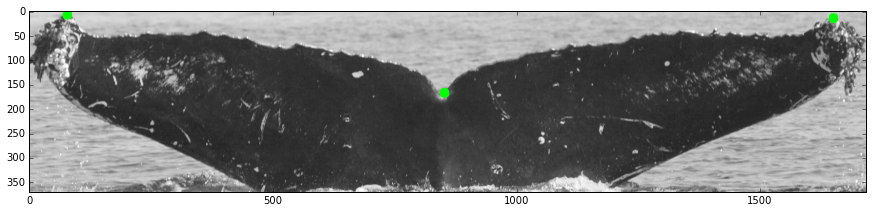

In [5]:
displayPoints(img_points_info['mediaAssets'][18])

In [6]:
for imginfo in img_points_info['mediaAssets']:
    if len(imginfo['referencePoints']) != 3:
        print(imginfo)

In [7]:
fb_curvatures = []
import utool as ut
for imginfo in ut.ProgressIter(img_points_info['mediaAssets'], lbl='Image'):
    img_url = imginfo['referenceImageURL']
    imgfn = downloadImage(img_url, cache=True)
    curvinfo = {'fn':imgfn.split('/')[-1],
                'id':imginfo['individualID'],}
    read_pts = lambda pts: {'x':int(float(pts['x'])), 'y':int(float(pts['y']))}
    img_points = sorted(map(read_pts, imginfo['referencePoints']), key=lambda x: x['x'])
    curvinfo['points'] = {'left':img_points[0], 'notch':img_points[1], 'right':img_points[2]}
    fb_curvatures.append(curvinfo)

Image    1/1315...  rate=23301.15 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:44 EST
Image    2/1315...  rate=3597.16 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:44 EST
Image    3/1315...  rate=4064.23 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:44 EST
Image    4/1315...  rate=3983.18 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:44 EST
Image    5/1315...  rate=4275.52 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:44 EST
Image    6/1315...  rate=4854.49 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:44 EST
Image    7/1315...  rate=4922.87 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:44 EST
Image    8/1315...  rate=4905.59 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:44 EST
Image    9/1315...  rate=4877.07 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:44 EST
Image   10/1315...  rate=4364.50 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:44 EST
Image   11/1315...  rate=4882.75 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:44 EST
Image   12/1315...  rate=4975.42 Hz, etr=0:00:00, ellapsed=0:00:00, wall=15:44 EST
Ima

In [8]:
from scipy.stats import norm
import numpy as np
def find_seam(img, start, end, center=None, n_neighbors=3, scale=1):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    assert(n_neighbors % 2 == 1)
    #n_neighbors = img.shape[0]
    neighbor_range = range(-1*(n_neighbors // 2),1+(n_neighbors // 2))
    #weight_df = [norm.pdf(x, scale=scale) for x in neighbor_range]
    # start and end are x,y 
    # take the vertical gradients of the image
    gradient_y_image = 1*cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    # TODO maybe: blur before taking gradients to denoise
    # set the start point's vertical gradient to a very high value
    # for each row from start to end, the cost of each cell is the max
    # of the three neighbors to its left + its own cost
    # the max that is chosen is then stored for each pixel in a column so we can backtrack
    gradient_y_image[:,start[0]] = np.inf # make sure this is where the path starts
    gradient_y_image[start[1],start[0]] = 0 #np.max(gradient_y_image) + 1 # yeah I think this makes sense
    
    gradient_y_image[:,end[0]] = np.inf
    gradient_y_image[end[1],end[0]] = 0 #np.max(gradient_y_image) + 1
    if center is not None:
        # force it to go through the center
        gradient_y_image[:,center[0]] = np.inf
        gradient_y_image[center[1],center[0]] = 0
    # the goal of the above is to make the path end at 'end', but that probably can't be guaranteed regardless
    cost = np.zeros(gradient_y_image.shape)
    back = np.zeros(gradient_y_image.shape,dtype=np.int32)
    get_cost = lambda row, col, i : np.inf if ((row+i < 0) or (row+i >= gradient_y_image.shape[0])) else cost[row+i,col-1] + gradient_y_image[row,col]
    for col in range(start[0],end[0]+1):
        # this is the slow part
        for row in range(gradient_y_image.shape[0]):
            #candidates = [((cost[cell+i, col-1]+gradient_y_image[cell,col]) if
            #              ((cell+i > 0) and (cell+i < gradient_y_image.shape[0])) else -np.inf) 
            #              for i in (-1,0,1)]
            candidates = [get_cost(row, col, i) for i in neighbor_range]
            best = np.argmin(candidates)
            #print(candidates)
            back[row, col] = best - (n_neighbors // 2)
            cost[row, col] = candidates[best]
    # backtrack the seam
    path = [] # we know that the path is from end to start so we don't need to store the x values
    curr_y = end[1]
    path_cost = 0
    # we know that the optimal path must end at the end point since otherwise its cost is -inf
    for col in range(start[0],end[0]+1)[::-1]:
        path_cost += cost[curr_y,col]
        path.append((col,curr_y)) 
        next_ = curr_y + back[curr_y,col]
        curr_y = next_
    #plt.imshow(cost)
    return path, path_cost, cost

import ctypes
lib = ctypes.cdll.LoadLibrary('../edge_match/icp_ctypes_cpp/ctypes_icp.so')
ndmat_f_type = np.ctypeslib.ndpointer(dtype=np.float32, ndim=2, flags='C_CONTIGUOUS')
ndmat_i_type = np.ctypeslib.ndpointer(dtype=np.int32, ndim=2, flags='C_CONTIGUOUS')

te_cpp = lib.find_trailing_edge
te_cpp.argtypes = [ndmat_f_type, ctypes.c_int, ctypes.c_int, # image and size info
                   ctypes.c_int, ctypes.c_int, ctypes.c_int, # startcol, endrow, endcol
                   ctypes.c_int, ndmat_i_type] # number of neighbors, output path

def find_trailing_edge_cpp(img, start, end, center, n_neighbors=5):
    # points are x,y
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    assert(n_neighbors % 2 == 1)
    gradient_y_image = 1*cv2.Sobel(img,cv2.CV_32F,0,1,ksize=5)
    
    gradient_y_image[:, start[0]] = np.inf
    gradient_y_image[start[1],start[0]] = 0
    
    gradient_y_image[:,end[0]] = np.inf
    gradient_y_image[end[1],end[0]] = 0
    
    gradient_y_image[:,center[0]] = np.inf
    gradient_y_image[center[1], center[0]] = 0
    
    outpath = np.zeros((end[0] - start[0], 2), dtype=np.int32)
    cost = te_cpp(gradient_y_image, gradient_y_image.shape[0], gradient_y_image.shape[1],
                  start[0], end[1], end[0], n_neighbors, outpath)
    return outpath, cost



In [9]:
from collections import defaultdict
id_img_map = defaultdict(lambda: [])
for imginfo in img_points_info['mediaAssets']:
    id_img_map[imginfo['individualID']].append(imginfo['referenceImageURL'])
    
def make_dict_hist(dic):
    hist = defaultdict(lambda: 0)
    for id_ in dic:
        hist[len(dic[id_])] += 1
    return hist

id_img_hist = make_dict_hist(id_img_map)

In [10]:
len(id_img_map)

776

In [ ]:
# before we do this, let's resize these images so that the X axis is always 960
# however it's important that we preserve the aspect ratio when doing this
# so what we should do is compute the aspect ratio of the image (x / y)
# we can set x arbitrarily (since that's the axis we're extracting / comparing edges over)

In [12]:
troubled_imgs = []

for imginfo, uriinfo in ut.ProgressIter(zip(fb_curvatures, img_points_info['mediaAssets'])):
    imgfn = downloadImage(uriinfo['referenceImageURL'], cache=False)
    img = cv2.imread(join(imgs_dir, imgfn))
    xyconvert = lambda pt: (pt['x'], pt['y'])
    if img.shape == (800,600,3):
        trouble_type = 1
        troubled_imgs.append((uriinfo['referenceImageURL'], trouble_type))

        
    try:
        path, cost = find_trailing_edge_cpp(img, 
                                            xyconvert(imginfo['points']['left']), 
                                            xyconvert(imginfo['points']['right']), 
                                            xyconvert(imginfo['points']['notch']),
                                            n_neighbors=5)z
    except IndexError:
        print("Extraction failed on image %s" % imginfo['fn'])
        trouble_type = 2
        troubled_imgs.append((uriinfo['referenceImageURL'], trouble_type))
        continue
    print(img.shape)
    imginfo['edge'] = path


lbl    0/1315...  (389, 2469, 3)
lbl    1/1315...  rate=3.69 Hz, etr=0:05:56, ellapsed=0:00:00, wall=15:48 EST
(519, 2508, 3)
lbl    2/1315...  rate=1.17 Hz, etr=0:18:42, ellapsed=0:00:01, wall=15:48 EST
(294, 1778, 3)
lbl    3/1315...  rate=2.95 Hz, etr=0:07:24, ellapsed=0:00:01, wall=15:48 EST
(529, 2605, 3)
lbl    4/1315...  rate=1.34 Hz, etr=0:16:16, ellapsed=0:00:02, wall=15:48 EST
(370, 879, 3)
lbl    5/1315...  rate=7.75 Hz, etr=0:02:48, ellapsed=0:00:02, wall=15:48 EST
(360, 1585, 3)
lbl    6/1315...  rate=4.45 Hz, etr=0:04:54, ellapsed=0:00:02, wall=15:48 EST
(634, 2373, 3)
lbl    7/1315...  rate=2.15 Hz, etr=0:10:08, ellapsed=0:00:03, wall=15:48 EST
Extraction failed on image extract54ad53c2-e3c6-4d03-a974-be4ef9dcfa29.jpg
lbl    8/1315...  rate=11.51 Hz, etr=0:01:53, ellapsed=0:00:03, wall=15:48 EST
(536, 1961, 3)
lbl    9/1315...  rate=3.32 Hz, etr=0:06:32, ellapsed=0:00:03, wall=15:48 EST
(839, 2401, 3)
lbl   10/1315...  rate=1.46 Hz, etr=0:14:56, ellapsed=0:00:04, wall=15

In [13]:
import json
with open(join(dataset_loc, 'flukebook_bad.json'), 'w') as f:
    json.dump(troubled_imgs, f)

In [14]:
print(fb_curvatures[-1]['edge'])

[[731  25]
 [730  26]
 [729  28]
 ..., 
 [ 13   9]
 [ 12   7]
 [ 11   7]]


In [15]:
print(len(troubled_imgs))

66


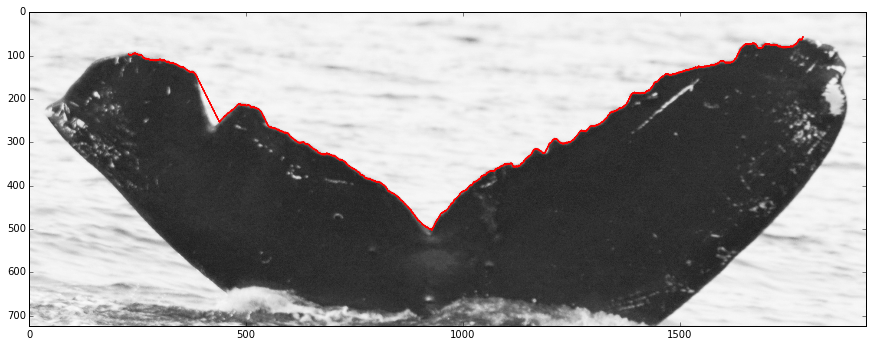

In [26]:
import random
def displayEdge(imginfo):
    img = cv2.imread(join(imgs_dir, imginfo['fn']))
    for edgePoint in imginfo['edge']:
        cv2.circle(img, tuple(edgePoint), 2, (255,0,0), thickness=-1)
    plt.figure(figsize=(15,15))
    plt.imshow(img)

displayEdge(random.choice(fb_curvatures))

In [30]:
curvatures_good = list(filter(lambda x: 'edge' in x, fb_curvatures))
curvatures_mult = filter(lambda x: len(
            filter(lambda y: y not in set(zip(*troubled_imgs)[0]), id_img_map[x['id']])) > 1, curvatures_good)

In [34]:
print(len(curvatures_mult))
import cPickle as pickle
with open(join(dataset_loc, "Flukes/Flukebook/fb_edges_mult_noresize.pkl"), 'w') as f:
    pickle.dump(curvatures_mult, f)

897


In [33]:
max([len(i['edge']) for i in curvatures_mult])

3745